### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [1]:
# Imports
import pandas as pd
import numpy as np
import sklearn.metrics
import autosklearn.classification
from sklearn.model_selection import train_test_split
from autosklearn.metrics import roc_auc, average_precision
from scipy.io import arff
from matplotlib import pyplot as plt

In [2]:
# Shuttle dataset
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
mat = loadmat('../data/shuttle.mat')  # load mat-file
X = mat['X']
y = mat['y']
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y = y[0]
N = 5000
if(len(X) > N):
    X = X.sample(n=N, ignore_index=True, random_state=1)
    y = y.sample(n=N, ignore_index=True, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y) # stratified split
# Reset indexes
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
#X_train_norm = X_train.copy()
#X_test_norm = X_test.copy()
#for col in X_train_norm.columns:
#    mu = X_train_norm[col].mean()
#    sig = X_train_norm[col].std()
#    X_train_norm[col] = (X_train_norm[col] - mu) / sig
#    X_test_norm[col] = (X_test_norm[col] - mu) / sig
#X_train = X_train_norm.copy()
#X_test = X_test_norm.copy()
print("Ratio of outliers in training set:", len(y_train[y_train==1])/len(y_train))
print("Ratio of outliers in test set:", len(y_test[y_test==1])/len(y_test))
print("Training size:", len(X_train))
print("Test size:", len(X_test))

Ratio of outliers in training set: 0.0675
Ratio of outliers in test set: 0.068
Training size: 4000
Test size: 1000


In [ ]:
# Import Auto-Sklearn implemented PyOD classifiers
from pyod_models.abod import ABODClassifier # probabilistic
from pyod_models.cblof import CBLOFClassifier # proximity-based
from pyod_models.cof import COFClassifier # proximity-based
from pyod_models.copod import COPODClassifier # probabilistic
from pyod_models.ecod import ECODClassifier # probabilistic
from pyod_models.hbos import HBOSClassifier # proximity-based
from pyod_models.iforest import IForestClassifier # outlier ensembles
from pyod_models.knn import KNNClassifier # proximity-based
from pyod_models.lmdd import LMDDClassifier # linear model
from pyod_models.loci import LOCIClassifier # proximity-based
from pyod_models.lof import LOFClassifier # proximity-based
from pyod_models.mad import MADClassifier # probabilistic
from pyod_models.mcd import MCDClassifier # linear model
from pyod_models.ocsvm import OCSVMClassifier # linear model
from pyod_models.pca import PCAClassifier # linear model
from pyod_models.rod import RODClassifier # proximity-based
from pyod_models.sod import SODClassifier # proximity-based
from pyod_models.sos import SOSClassifier # probabilistic
# Add algorithms to the pipeline components of Auto-Sklearn
autosklearn.pipeline.components.classification.add_classifier(ABODClassifier)
autosklearn.pipeline.components.classification.add_classifier(CBLOFClassifier)
autosklearn.pipeline.components.classification.add_classifier(COFClassifier)
autosklearn.pipeline.components.classification.add_classifier(COPODClassifier)
autosklearn.pipeline.components.classification.add_classifier(ECODClassifier)
autosklearn.pipeline.components.classification.add_classifier(HBOSClassifier)
autosklearn.pipeline.components.classification.add_classifier(IForestClassifier)
autosklearn.pipeline.components.classification.add_classifier(KNNClassifier)
autosklearn.pipeline.components.classification.add_classifier(LMDDClassifier)
autosklearn.pipeline.components.classification.add_classifier(LOCIClassifier)
autosklearn.pipeline.components.classification.add_classifier(LOFClassifier)
autosklearn.pipeline.components.classification.add_classifier(MADClassifier)
autosklearn.pipeline.components.classification.add_classifier(MCDClassifier)
autosklearn.pipeline.components.classification.add_classifier(OCSVMClassifier)
autosklearn.pipeline.components.classification.add_classifier(PCAClassifier)
autosklearn.pipeline.components.classification.add_classifier(RODClassifier)
autosklearn.pipeline.components.classification.add_classifier(SODClassifier)
autosklearn.pipeline.components.classification.add_classifier(SOSClassifier)

SyntaxError: invalid syntax (3481494486.py, line 2)

In [14]:
# Pre-defined split indices for train and validation
selected_indices = []
sacrificed_outliers = 0 # count of outliers sampled for the training set
for v in y_train:
    if v==1: # outlier
        if np.random.rand()>0.05:
            selected_indices.append(1) # validation
        else:
            selected_indices.append(0) # training
            sacrificed_outliers += 1 # will not be used for evaluation
    else:
        if np.random.rand()>0.9:
            selected_indices.append(1) # validation
        else:
            selected_indices.append(0) # training
# prints
print('Length of selected indices:', len(selected_indices))
print('Number of total samples:', len(y_train))
print('Number of outliers:', sum(y_train))
print('Number of sacrificed outliers:', sacrificed_outliers)
print('Number of validation samples:', sum(selected_indices))
print('Number of training samples:', len(y_train) - sum(selected_indices))

Length of selected indices: 4000
Number of total samples: 4000
Number of outliers: 270
Number of sacrificed outliers: 11
Number of validation samples: 609
Number of training samples: 3391


In [15]:
# Build and fit a classifier
resampling_strategy = sklearn.model_selection.PredefinedSplit(test_fold=selected_indices)
automl = autosklearn.classification.AutoSklearnClassifier(
    include = {
      'classifier': [
          'ABODClassifier',
          'CBLOFClassifier',
          #'COFClassifier',
          'COPODClassifier',
          'ECODClassifier',
          'HBOSClassifier',
          'IForestClassifier',
          'KNNClassifier',
          'LMDDClassifier',
          'LOCIClassifier',
          'LOFClassifier',
          #'MADClassifier', # only for univariate data
          'MCDClassifier',
          'OCSVMClassifier',
          'PCAClassifier',
          'RODClassifier',
          'SODClassifier',
          'SOSClassifier'
      ],
      'feature_preprocessor': ["no_preprocessing"],
    },
    exclude=None,
    metric=roc_auc,
    scoring_functions = [ roc_auc, average_precision],
    time_left_for_this_task=600,
    per_run_time_limit=30,
    ensemble_size=1,
    initial_configurations_via_metalearning=0,
    delete_tmp_folder_after_terminate=False,
    resampling_strategy=resampling_strategy,
    #resampling_strategy_arguments={'train_size': 0.67}
    #resampling_strategy='cv',
    #resampling_strategy_arguments={'folds': 10}
)
# Fit
print('Running fit...')
automl.fit(X_train, y_train, X_test, y_test, dataset_name='Shuttle')

Running fit...


AutoSklearnClassifier(delete_tmp_folder_after_terminate=False, ensemble_size=1,
                      include={'classifier': ['ABODClassifier',
                                              'CBLOFClassifier',
                                              'COPODClassifier',
                                              'ECODClassifier',
                                              'HBOSClassifier',
                                              'IForestClassifier',
                                              'KNNClassifier', 'LMDDClassifier',
                                              'LOCIClassifier', 'LOFClassifier',
                                              'MCDClassifier',
                                              'OCSVMClassifier',
                                              'PCAClassifier', 'RODClassifier',
                                              'SODClassifier',
                                              'SOSClassifier'],
                               'fe

In [16]:
# auto-sklearn execution details
print(automl.sprint_statistics())
# Top ranked model
#print(automl.leaderboard(top_k=10))
# Top ranked model configuration
#print()
#print(automl.show_models())

auto-sklearn results:
  Dataset name: Shuttle
  Metric: roc_auc
  Best validation score: 0.995356
  Number of target algorithm runs: 69
  Number of successful target algorithm runs: 54
  Number of crashed target algorithm runs: 6
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 0



In [17]:
print('Running refit...')
automl.refit(X_train, y_train)
# Evaluate on test set
y_pred=automl.predict_proba(X_test)
# score
score=sklearn.metrics.roc_auc_score(y_test,y_pred[:,1])
print("ROC AUC score:", score)

Running refit...
ROC AUC score: 0.985972607927291


In [18]:
# Get metric results function definition
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    #results = results[results['status'] == "Success"] # if we're interested only in successful runs
    cols = ['rank_test_scores', 'status', 'param_classifier:__choice__', 'mean_test_score', 'mean_fit_time']
    cols.extend([key for key in cv_results.keys() if key.startswith('metric_')]) # if there are additional metrics
    return results[cols].sort_values(['rank_test_scores'])
# Call the function
print(get_metric_result(automl.cv_results_).to_string(index=False))

 rank_test_scores  status param_classifier:__choice__  mean_test_score  mean_fit_time  metric_roc_auc  metric_average_precision
                1 Success             COPODClassifier         0.995356       1.798468        0.995356                  0.428383
                1 Success             COPODClassifier         0.995356       2.119617        0.995356                  0.428383
                1 Success             COPODClassifier         0.995356       2.097987        0.995356                  0.428383
                1 Success             COPODClassifier         0.995356       2.325945        0.995356                  0.428383
                1 Success             COPODClassifier         0.995356       2.381931        0.995356                  0.428383
                1 Success             COPODClassifier         0.995356       2.282411        0.995356                  0.428383
                1 Success             COPODClassifier         0.995356       2.206191        0.995356   

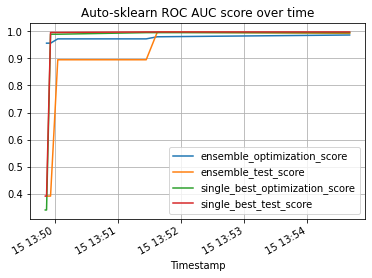

In [19]:
# Plot training performance over time
automl.performance_over_time_.plot(
   x='Timestamp',
   kind='line',
   legend=True,
   title='Auto-sklearn ROC AUC score over time',
   grid=True,
)
plt.show()

In [ ]:
#import pickle
# Save trained model
#with open('model.pkl', 'wb') as f:
#    pickle.dump(automl, f)
# Load saved model
#with open('model.pkl' , 'rb') as f:
#    mdl = pickle.load(f)
#mdl.show_models()